# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

This is a classificaiton problem, as target model will predict if student belongs to the class of students that requires intervention. 

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1745]:
get_ipython().magic(u'matplotlib inline')
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from time import time
from __future__ import division
from sklearn import cross_validation

from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [1746]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [1747]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1]-1
n_passed = student_data.loc[student_data['passed']=='yes'].shape[0]
n_failed = n_students-n_passed
grad_rate = 100*n_passed/n_students
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [1748]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  reason guardian  traveltime  studytime  failures schoolsup famsup paid activities nursery higher internet romantic  famrel  freetime  goout  Dalc  Walc  health  absences
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  course   mother           2          2         0       yes     no   no         no     yes    yes       no       no       4         3      4     1     1       3         6
1     GP   F   17       U     GT3       T     1     1  at_home     other  course   father           1          2         0        no    yes   

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [1749]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [1750]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train


# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size=num_test, random_state=0)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [1751]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    clf_train_time=end-start
    return clf_train_time

# TODO: Choose a model, import it and instantiate an object
from sklearn.svm import SVC
clf = SVC()

# Fit model to training data
clf_train_time=train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it
print "classifier: ", clf

Training SVC...
classifier:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [1752]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    time_taken=end-start
    f1score=f1_score(target.values, y_pred, pos_label='yes')
    return time_taken, f1score

predict_all_train_time, predict_all_train_f1score = predict_labels(clf, X_train, y_train)
print "Predict Training labels Time taken: {:.5f}, F1 Score : {:.5f}".format(predict_all_train_time,predict_all_train_f1score)


Predicting labels using SVC...
Predict Training labels Time taken: 0.00662, F1 Score : 0.86920


In [1753]:
# Predict on test data
predict_all_test_time, predict_all_test_f1score=predict_labels(clf, X_test, y_test)
print "Predict Test labels Time taken: {:.5f}, F1 Score : {:.5f}".format(predict_all_test_time,predict_all_test_f1score)


Predicting labels using SVC...
Predict Test labels Time taken: 0.00241, F1 Score : 0.75862


In [1754]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    clf_train_time=train_classifier(clf, X_train, y_train)
    train_time, train_score=predict_labels(clf, X_train, y_train)
    print "Training set Time taken: {:.5f}, f1score: {:.5f}".format(train_time, train_score)
    test_time, test_score=predict_labels(clf, X_test, y_test)
    print "Test set Time taken: {:.5f}, f1score: {:.5f}".format(test_time, test_score)
    return clf_train_time, test_time, train_score, test_score

## Create DataFrames to hold Accuracy matrix, 
# and another to the matrix required for project specs.
test_f1score_time_matrix=pd.DataFrame(columns=['TST_F1_SVC','TST_F1_AB','TST_F1_RF',
                                          'Trng_size',
                                          'TST_TIME_SVC','TST_TIME_AB','TST_TIME_RF'],
                                             index=['50','100','150','200','250','300'])
test_f1score_time_matrix['Trng_size']=[50,100,150,200,250,300]


project_data_matrix=pd.DataFrame(columns=['50','100','150','200','250','300'],
                                 index=['Training time (secs)','Prediction time (secs)',
                                        'F1 score for training set',
                                        'F1 score for test set'])



In [1755]:
# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

# Clf #1:  SVC
for i in range(1,7):
    # Creating a new instance of SVC Classifier to avoid any mixup with previous instance.
    clf = SVC()
    train_time, predict_test_time, predict_train_score, predict_test_score=train_predict(clf, X_train[0:(50*i)],y_train[0:(50*i)],X_test,y_test)
    project_data_matrix.iloc[0,i-1]=train_time
    project_data_matrix.iloc[1,i-1]=predict_test_time
    project_data_matrix.iloc[2,i-1]=predict_train_score
    project_data_matrix.iloc[3,i-1]=predict_test_score
    test_f1score_time_matrix['TST_F1_SVC'][i-1]=predict_test_score
    test_f1score_time_matrix['TST_TIME_SVC'][i-1]=predict_test_time
    
print "\n",'-'*80  
print "SVC data matrix"
print project_data_matrix
print '-'*80  

------------------------------------------
Training set size: 50
Training SVC...
Predicting labels using SVC...
Training set Time taken: 0.00045, f1score: 0.90625
Predicting labels using SVC...
Test set Time taken: 0.00058, f1score: 0.73438
------------------------------------------
Training set size: 100
Training SVC...
Predicting labels using SVC...
Training set Time taken: 0.00098, f1score: 0.85906
Predicting labels using SVC...
Test set Time taken: 0.00090, f1score: 0.78378
------------------------------------------
Training set size: 150
Training SVC...
Predicting labels using SVC...
Training set Time taken: 0.00181, f1score: 0.87081
Predicting labels using SVC...
Test set Time taken: 0.00121, f1score: 0.77143
------------------------------------------
Training set size: 200
Training SVC...
Predicting labels using SVC...
Training set Time taken: 0.00296, f1score: 0.86928
Predicting labels using SVC...
Test set Time taken: 0.00145, f1score: 0.77551
---------------------------------

In [1756]:
# TODO: Train and predict using two other models
# Clf #2 uses Boosting: AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

for i in range(1,7):
    # Creating a new instance of DecisionTree Classifier to avoid any mixup with previous instance.
    dt_clf=DecisionTreeClassifier()
    clf = AdaBoostClassifier(dt_clf)
    train_time, predict_test_time, 
    train_time, predict_test_time, predict_train_score, predict_test_score=train_predict(clf, 
                                                  X_train[0:(50*i)],
                                                  y_train[0:(50*i)],
                                                  X_test,
                                                  y_test)
    project_data_matrix.iloc[0,i-1]=train_time
    project_data_matrix.iloc[1,i-1]=predict_test_time
    project_data_matrix.iloc[2,i-1]=predict_train_score
    project_data_matrix.iloc[3,i-1]=predict_test_score
    test_f1score_time_matrix['TST_F1_AB'][i-1]=predict_test_score
    test_f1score_time_matrix['TST_TIME_AB'][i-1]=predict_test_time
    
print "\n",'-'*80  
print "Ada Boost data matrix"
print project_data_matrix
print '-'*80  

------------------------------------------
Training set size: 50
Training AdaBoostClassifier...
Predicting labels using AdaBoostClassifier...
Training set Time taken: 0.00067, f1score: 1.00000
Predicting labels using AdaBoostClassifier...
Test set Time taken: 0.00041, f1score: 0.68966
------------------------------------------
Training set size: 100
Training AdaBoostClassifier...
Predicting labels using AdaBoostClassifier...
Training set Time taken: 0.00032, f1score: 1.00000
Predicting labels using AdaBoostClassifier...
Test set Time taken: 0.00032, f1score: 0.71795
------------------------------------------
Training set size: 150
Training AdaBoostClassifier...
Predicting labels using AdaBoostClassifier...
Training set Time taken: 0.00041, f1score: 1.00000
Predicting labels using AdaBoostClassifier...
Test set Time taken: 0.00032, f1score: 0.72441
------------------------------------------
Training set size: 200
Training AdaBoostClassifier...
Predicting labels using AdaBoostClassifier.

In [1757]:
# TODO: Train and predict using two other models
# Clf #3 uses bagging:  Random Forest
from sklearn.ensemble import RandomForestClassifier

for i in range(1,7):
    # Creating a new instance of DecisionTree Classifier to avoid any mixup with previous instance.
    clf = RandomForestClassifier()
    train_time, predict_test_time, predict_train_score, predict_test_score=train_predict(clf, 
                                                  X_train[0:(50*i)],
                                                  y_train[0:(50*i)],
                                                  X_test,
                                                  y_test)
    project_data_matrix.iloc[0,i-1]=train_time
    project_data_matrix.iloc[1,i-1]=predict_test_time
    project_data_matrix.iloc[2,i-1]=predict_train_score
    project_data_matrix.iloc[3,i-1]=predict_test_score
    test_f1score_time_matrix['TST_F1_RF'][i-1]=predict_test_score
    test_f1score_time_matrix['TST_TIME_RF'][i-1]=predict_test_time
    
print "\n",'-'*80  
print "Random Forest data matrix"
print project_data_matrix
print '-'*80 

------------------------------------------
Training set size: 50
Training RandomForestClassifier...
Predicting labels using RandomForestClassifier...
Training set Time taken: 0.00142, f1score: 1.00000
Predicting labels using RandomForestClassifier...
Test set Time taken: 0.00128, f1score: 0.67826
------------------------------------------
Training set size: 100
Training RandomForestClassifier...
Predicting labels using RandomForestClassifier...
Training set Time taken: 0.00115, f1score: 1.00000
Predicting labels using RandomForestClassifier...
Test set Time taken: 0.00103, f1score: 0.72727
------------------------------------------
Training set size: 150
Training RandomForestClassifier...
Predicting labels using RandomForestClassifier...
Training set Time taken: 0.00125, f1score: 0.98925
Predicting labels using RandomForestClassifier...
Test set Time taken: 0.00115, f1score: 0.76692
------------------------------------------
Training set size: 200
Training RandomForestClassifier...
Pre


--------------------------------------------------------------------------------
Accuracy score and time taken for various models, given diffferent training data sizes.

--------------------------------------------------------------------------------
    TST_F1_SVC TST_F1_AB TST_F1_RF  Trng_size TST_TIME_SVC TST_TIME_AB TST_TIME_RF
50     0.73438   0.68966   0.67826         50      0.00058     0.00041     0.00128
100    0.78378   0.71795   0.72727        100      0.00090     0.00032     0.00103
150    0.77143   0.72441   0.76692        150      0.00121     0.00032     0.00115
200    0.77551   0.75385   0.78571        200      0.00145     0.00032     0.00094
250    0.75862   0.71186   0.71533        250      0.00156     0.00045     0.00119
300    0.75862   0.73333   0.74016        300      0.00197     0.00033     0.00140

--------------------------------------------------------------------------------


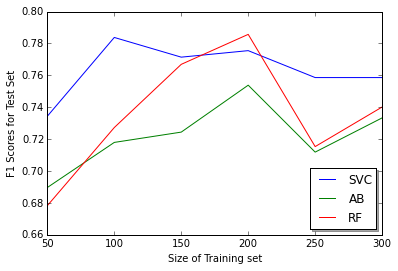

In [1758]:
# Display results data below.
print "\n",'-'*80
print "Accuracy score and time taken for various models, given diffferent training data sizes."
print "\n",'-'*80
print test_f1score_time_matrix
print "\n",'-'*80  

plt.plot(test_f1score_time_matrix['Trng_size'].values,test_f1score_time_matrix['TST_F1_SVC'].values,label='SVC')
plt.plot(test_f1score_time_matrix['Trng_size'].values,test_f1score_time_matrix['TST_F1_AB'].values,label='AB')
plt.plot(test_f1score_time_matrix['Trng_size'].values,test_f1score_time_matrix['TST_F1_RF'].values,label='RF')
plt.legend(loc='lower right', shadow=True)
plt.ylabel("F1 Scores for Test Set")
plt.xlabel("Size of Training set")
plt.show()



## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [1759]:
# TODO: Fine-tune your model and report the best F1 score

# Tune AdaBoost
selected_model_matrix=pd.DataFrame(columns=['50','100','150','200','250','300'],
                                 index=['Training time (secs)','Prediction time (secs)',
                                        'F1 score for training set',
                                        'F1 score for test set'])
learning_rate=0.70
for i in range(1,7):
    # Creating a new instance of DecisionTree Classifier to avoid any mixup with previous instance.
    dt_clf=DecisionTreeClassifier(presort=True, min_samples_leaf=1,max_depth=1,max_features=26)
    clf = AdaBoostClassifier(dt_clf,algorithm="SAMME",n_estimators=20,learning_rate=learning_rate)
    train_time, predict_test_time, predict_train_score, predict_test_score=train_predict(clf, 
                                                  X_train[0:(50*i)],y_train[0:(50*i)],
                                                  X_test,y_test)
    selected_model_matrix.iloc[0,i-1]=train_time
    selected_model_matrix.iloc[1,i-1]=predict_test_time
    selected_model_matrix.iloc[2,i-1]=predict_train_score
    selected_model_matrix.iloc[3,i-1]=predict_test_score
    
print "\n",'-'*80  
print "Selected Model (Ada Boost) data matrix"
print selected_model_matrix
print '-'*80  

------------------------------------------
Training set size: 50
Training AdaBoostClassifier...
Predicting labels using AdaBoostClassifier...
Training set Time taken: 0.00166, f1score: 0.94915
Predicting labels using AdaBoostClassifier...
Test set Time taken: 0.00262, f1score: 0.72581
------------------------------------------
Training set size: 100
Training AdaBoostClassifier...
Predicting labels using AdaBoostClassifier...
Training set Time taken: 0.00170, f1score: 0.82857
Predicting labels using AdaBoostClassifier...
Test set Time taken: 0.00151, f1score: 0.75912
------------------------------------------
Training set size: 150
Training AdaBoostClassifier...
Predicting labels using AdaBoostClassifier...
Training set Time taken: 0.00196, f1score: 0.80976
Predicting labels using AdaBoostClassifier...
Test set Time taken: 0.00172, f1score: 0.79710
------------------------------------------
Training set size: 200
Training AdaBoostClassifier...
Predicting labels using AdaBoostClassifier.

In [ ]:
from sklearn import grid_search

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME", "SAMME.R"],
              "n_estimators": [5,8,10,11,12,13,14,15,17,20,22,24,26,28,30,40,48],
              "learning_rate":[0.7,0.8,0.9,1.0]
             }

DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "auto",max_depth = None)

ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
grid_search_ABC = grid_search.GridSearchCV(ABC, param_grid=param_grid,cv=4)
gs_estimator=grid_search_ABC.fit(X_train,y_train)
print "gs_estimator", gs_estimator
print "Best model parameter:  " + str(gs_estimator.best_params_)
y_pred=grid_search_ABC.predict(X_test)
gs_f1score=f1_score(y_test, y_pred,pos_label="yes")
print gs_f1score